In [59]:
#import dependencies
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import pymongo 
from sqlalchemy import create_engine 
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# conn = 'mongodb://localhost:27017'
# client = pymongo.MongoClient(conn)


In [2]:
filepath = 'resources/alcoholSubstanceAbuse.csv'


In [3]:
df = pd.read_csv(filepath)
df = df.rename(columns={'Location':'Country','Dim1':'Sex','First Tooltip':'Total alcohol per capita'})
df = df.drop(columns=['Indicator'])
# df.groupby(['Country', 'Sex'])
df.head(20)

,Country,Period,Sex,Total alcohol per capita
0,Afghanistan,2018,Both sexes,0.210
1,Afghanistan,2018,Male,0.360
2,Afghanistan,2018,Female,0.055
3,Afghanistan,2015,Both sexes,0.210
4,Afghanistan,2015,Male,0.350
5,Afghanistan,2015,Female,0.054
6,Afghanistan,2010,Both sexes,0.210
7,Afghanistan,2010,Male,0.360
8,Afghanistan,2010,Female,0.054
9,Albania,2018,Both sexes,7.170


In [4]:
# idx = pd.IndexSlice 
# df = df.loc[idx[:,[2018],['Both sexes'],:],:]
# df

df = df[(df['Period']==2018) & (df['Sex']== 'Both sexes')]
df

,Country,Period,Sex,Total alcohol per capita
0,Afghanistan,2018,Both sexes,0.210
9,Albania,2018,Both sexes,7.170
24,Algeria,2018,Both sexes,0.950
39,Andorra,2018,Both sexes,11.020
54,Angola,2018,Both sexes,6.940
...,...,...,...,...
2712,Venezuela (Bolivarian Republic of),2018,Both sexes,4.140
2727,Viet Nam,2018,Both sexes,8.660
2742,Yemen,2018,Both sexes,0.051
2757,Zambia,2018,Both sexes,6.540


In [17]:
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita'
raw = pd.read_html(url)
# raw

In [31]:
df_percapita = raw[0]
df_percapita
df_percapita = df_percapita.drop([0,1,2])
df_percapita = df_percapita.rename(columns={0:'Rank',1:'Country', 2:'GDP Per Capita'})
df_percapita.reset_index(drop=True, inplace=True)
# df_percapita.drop(indexNames , inplace=True)

# Let’s delete all rows for which column ‘Age’ has value 30 i.e.
# Get names of indexes for which column Age has value 30
indexNames = df_percapita[df_percapita['GDP Per Capita'] == 'US$'].index
# indexNames = df_percapita[df_percapita['GDP Per Capita'] == 'nan'].index == this line does not work

# Delete these row indexes from dataFrame
df_percapita.drop(indexNames , inplace=True)

df_percapita.dropna(subset=['GDP Per Capita'], inplace=True)
# df_percapita = df_percapita.drop(df_percapita.loc[df_percapita['GDP Per Capita']=='US$'], inplace=True)
# df_percapita = df_percapita.groupby('Country')['GDP Per Capita'].mean()
# df_percapita = df_percapita.mean('GDP Per Capita')
# groupby country and avg per capita
# df_percapita['GDP Per Capita'].dtypes
# use df["col"]. astype(str). astype(int)
df_percapita["GDP Per Capita"] = df_percapita["GDP Per Capita"].astype(str).astype(int)
df_percapita = df_percapita.groupby('Country')['GDP Per Capita'].mean()
df_percapita

Country
Afghanistan                    490.333333
Africa                        1884.000000
Albania                       5184.666667
Algeria                       3751.666667
Americas                     28239.000000
                                 ...     
West Bank and Gaza (2008)     3199.000000
World                        11384.000000
Yemen                          822.666667
Zambia                        1194.666667
Zimbabwe                      1283.333333
Name: GDP Per Capita, Length: 231, dtype: float64

In [32]:
# df_percapita['GDP Per Capita'].unique()

KeyError: 'GDP Per Capita'

In [49]:
# merge dfs based on 'country'
new_df = pd.merge(df, df_percapita, on='Country')
# new_df = df_percapita.groupby('Country')['GDP Per Capita'].mean()
new_df = new_df.rename(columns={'Country':'country', 'Period':'period', 'Sex':'sex', 'Total alcohol per capita':'total_alcohol_per_capita','GDP Per Capita':'gdp_per_capita'})
new_df

,country,period,sex,total_alcohol_per_capita,gdp_per_capita
0,Afghanistan,2018,Both sexes,0.210,490.333333
1,Albania,2018,Both sexes,7.170,5184.666667
2,Algeria,2018,Both sexes,0.950,3751.666667
3,Andorra,2018,Both sexes,11.020,40886.500000
4,Angola,2018,Both sexes,6.940,2555.333333
...,...,...,...,...,...
157,Uzbekistan,2018,Both sexes,2.590,1748.000000
158,Vanuatu,2018,Both sexes,2.250,2986.666667
159,Yemen,2018,Both sexes,0.051,822.666667
160,Zambia,2018,Both sexes,6.540,1194.666667


In [55]:
rds_connection_string = "postgres:postgres@localhost:5432/etl_db"
engine = create_engine(f'postgresql://{rds_connection_string}')

In [56]:
engine.table_names()

['gdp_alcohol']

In [57]:
# engine = create_engine(f'postgresql://{rds_connection_string}')
new_df.to_sql(name="gdp_alcohol", con=engine, if_exists='append', index=False)


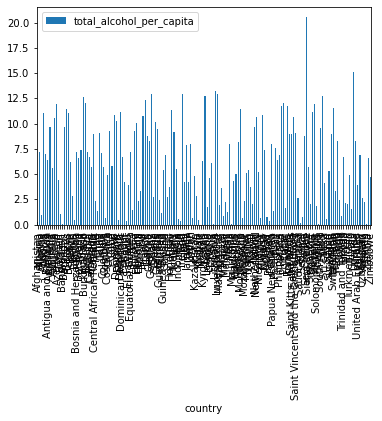

In [69]:
new_df.plot.bar(x='country', y='total_alcohol_per_capita')
plt.show()